# US Candy Production Dataset: Time Series and Uncertainty Estimate Exercise

**Data source**: [Kaggle](https://www.kaggle.com/rtatman/us-candy-production-by-month)

**Content** :
The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories. This dataset tracks industrial production every month from January 1972 to August 2017.

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import LSTM
from keras.regularizers import l2

import numpy as np
import tensorflow as tf
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
df = pd.read_csv('candy_production.csv', header=0, index_col = 0,squeeze=True)
raw_values = df.values
raw_keys = df.keys()

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64

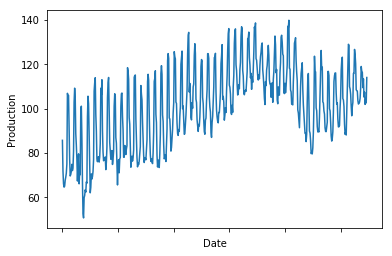

In [6]:
# Look at the first 5 entries and plot the series
plt.xlabel("Date")
plt.ylabel("Production")
df.plot()
df.head(5)

### Transform time series to stationary

In [7]:
def to_stationary(dataset, interval=1):
    '''Routine that takes the original time series
       and remove any trend.'''
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.DataFrame(diff)

In [8]:
def inverse_stationary(history, yhat, interval=1):
    '''Takes the stationary time series and reverts back 
       to original time series with trends.'''
    inverted = list()
    for i in range(0,len(yhat)):
        value = yhat[i] + history[-(len(history)-i)]
        inverted.append(value)
    return pd.DataFrame(inverted)

In [9]:
def inverse_stationary2(history, yhat, interval=1):
    return yhat + history[-interval]

In [10]:
raw_values_stationary = to_stationary(raw_values, 1)
inverted = inverse_stationary(raw_values, raw_values_stationary.values, 1)

In [11]:
print(df.head(5))
print(raw_values_stationary.head(5))
print(inverted.head(5))

Date
1/1/1972    85.6945
2/1/1972    71.8200
3/1/1972    66.0229
4/1/1972    64.5645
5/1/1972    65.0100
Name: IP, dtype: float64
         0
0 -13.8745
1  -5.7971
2  -1.4584
3   0.4455
4   2.6367
         0
0  71.8200
1  66.0229
2  64.5645
3  65.0100
4  67.6467


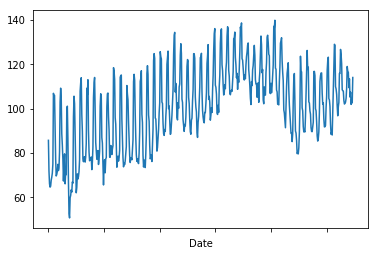

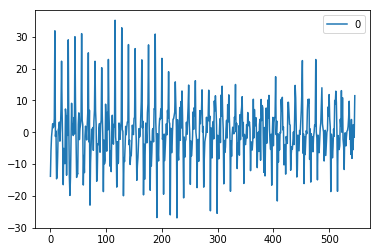

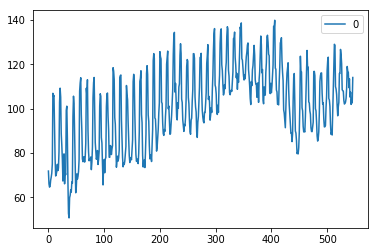

In [12]:
#-- Check by plotting
df.plot()
raw_values_stationary.plot()
inverted.plot()

### Create supervised learning series

In [13]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [14]:
supervised = timeseries_to_supervised(raw_values_stationary, lag=1)
supervised_val = supervised.values

### Split train and test sets

In [15]:
splitIdx = int(len(supervised_val) * 0.7)
train, test = supervised_val[0:splitIdx], supervised_val[splitIdx:]
#print(splitIdx)
#print(len(test))

### Scale the data

In [16]:
def scale(train, test):
    '''Scale the supervised time series data to 
       oscillate between -1 to 1.'''
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler = scaler.fit(train)
    
    # Transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # Transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [17]:
def invert_scale(scaler, X, value):
    '''Reverses the scaling done on the 
       time series data.'''
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0,-1]

In [18]:
scaler, train_scaled, test_scaled = scale(train, test)

### Fit the model

In [19]:
#-- Initialize parameters for LSTM model
look_back       = 1
batch_size      = 1
lbd             = 1e-4    # For l2 regularization
p_drop          = 0.5     # dropout rate for LSTM layer, dropout
p_dropRecurrent = 0.25    # dropout rate for LSTM layer, recurrent dropout
p_dropDense     = 0.1     # dropout rate for Dense layer

#-- Separate sets into X and y components
Xtrain, ytrain = train_scaled[:,0:-1], train_scaled[:,-1]
Xtest, ytest = test_scaled[:,0:-1], test_scaled[:,-1]

#-- Reshape X sets for LSTM model
Xtrain = Xtrain.reshape(Xtrain.shape[0], 1, Xtrain.shape[1])
Xtest = Xtest.reshape(Xtest.shape[0], 1, Xtest.shape[1])

In [20]:
Xtrain[0].shape

(1, 1)

In [21]:
# Functional API
'''
inputs = Input(batch_shape=(batch_size, time_step,1))
lstm = LSTM(4, dropout=p_drop, stateful=True, kernel_regularizer=l2(lbd))(inputs, training=True)
inter = Dropout(p_dropDense)(lstm, training=True)
dense = Dense(1, kernel_regularizer=l2(lbd))(inter)

model = Model(inputs=inputs, outputs=dense)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
'''

'''Note: This turns out to be very slow.'''

'Note: This turns out to be very slow.'

In [22]:
# Sequential API

#-- Construct LSTM model
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, look_back,1), 
               dropout=p_drop, recurrent_dropout=p_dropRecurrent,
               stateful=True, kernel_regularizer=l2(lbd)))
model.add(Dropout(p_dropDense))
model.add(Dense(1, kernel_regularizer=l2(lbd)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 4)                    96        
_________________________________________________________________
dropout_1 (Dropout)          (1, 4)                    0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [23]:
#-- Train the model
model.fit(Xtrain,ytrain, epochs=25, batch_size=batch_size, verbose=2, shuffle=False)

Epoch 1/25
 - 1s - loss: 0.1018
Epoch 2/25
 - 0s - loss: 0.0947
Epoch 3/25
 - 0s - loss: 0.0911
Epoch 4/25
 - 0s - loss: 0.0906
Epoch 5/25
 - 0s - loss: 0.0872
Epoch 6/25
 - 0s - loss: 0.0865
Epoch 7/25
 - 0s - loss: 0.0858
Epoch 8/25
 - 0s - loss: 0.0860
Epoch 9/25
 - 0s - loss: 0.0861
Epoch 10/25
 - 0s - loss: 0.0828
Epoch 11/25
 - 0s - loss: 0.0800
Epoch 12/25
 - 0s - loss: 0.0835
Epoch 13/25
 - 0s - loss: 0.0778
Epoch 14/25
 - 0s - loss: 0.0804
Epoch 15/25
 - 0s - loss: 0.0789
Epoch 16/25
 - 0s - loss: 0.0841
Epoch 17/25
 - 0s - loss: 0.0834
Epoch 18/25
 - 0s - loss: 0.0758
Epoch 19/25
 - 0s - loss: 0.0839
Epoch 20/25
 - 0s - loss: 0.0777
Epoch 21/25
 - 0s - loss: 0.0778
Epoch 22/25
 - 0s - loss: 0.0788
Epoch 23/25
 - 0s - loss: 0.0783
Epoch 24/25
 - 0s - loss: 0.0768
Epoch 25/25
 - 0s - loss: 0.0821


In [24]:
def lstm_forecast(model, batch_size, X):
    '''Takes the trained LSTM model and make
       prediction.'''
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [25]:
#-- Compare the predicted values of LSTM model and original time series

predictions = []
expectations = []
for i in range(0,len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = lstm_forecast(model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_stationary2(raw_values, yhat, len(test_scaled)+1 - i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i]
    expectations.append(expected)
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

0.9534809668321018

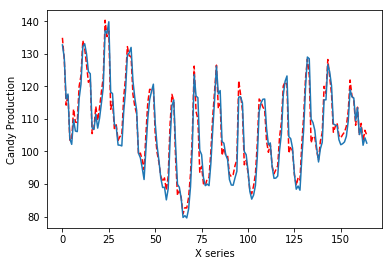

In [35]:
#-- Plot the results
#-- Red, Dashed = LSTM model
#-- Blue = Original time series
plt.xlabel('X series')
plt.ylabel('Candy Production')
plt.plot(predictions,'r--')
plt.plot(expectations)
metrics.r2_score(expectations, predictions)

### Monte Carlo (MC) Dropout for CI Estimates

In [27]:
#-- Define backend function (from Keras) for MC dropout
predict_stochastic = K.function([model.layers[0].input, K.learning_phase()], [model.layers[-1].output])

In [28]:
# Another way to implement MC Dropout
#class MCDropout(keras.layers.Dropout):
#    def call(self, inputs, training=None):
#        return super(MCDropout, self).call(inputs, training=True)

In [29]:
T = 500    # Sample size
yhat_mc = np.array([predict_stochastic([Xtest,1]) for _ in range(T)])
#yhat_mc = np.array([model.predict(Xtest, batch_size=1) for _ in range(T)])
yhat_mc = yhat_mc.reshape(-1, ytest.shape[0]).T
yhat_mc.shape

(165, 500)

In [30]:
l = 10
yhat_test_mean = np.mean(yhat_mc, axis=1)
yhat_test_variance = np.var(yhat_mc, axis=1)
tau = l**2 *(1-p_drop) / (2 * Xtrain.shape[0] * lbd)
yhat_test_variance += tau**-1
yhat_test_mean.shape

(165,)

In [31]:
ytest_mean_inverse=[]
for i in range(0,len(yhat_test_mean)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = yhat_test_mean[i]
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_stationary2(raw_values, yhat, len(test_scaled)+1 - i)
    ytest_mean_inverse.append(yhat)
    #print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))


0.9608002616386084

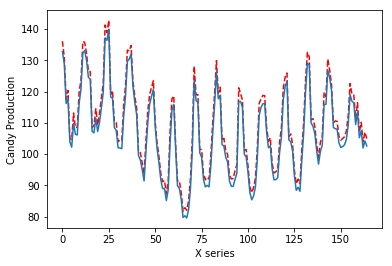

In [37]:
#-- Sanity check: Compare LSTM model from using backend function to original time series
plt.xlabel('X series')
plt.ylabel('Candy Production')
plt.plot(ytest_mean_inverse,'r--')
plt.plot(expectations)
metrics.r2_score(expectations,ytest_mean_inverse)

In [33]:

#-- Look at one of the predictions
month         = 0
monthStr      = raw_keys[len(train) + month]
y_expected = raw_values[len(train) + month]
yhat_test     = yhat_mc[month,:]
yhat          = []
for i in range(0, len(yhat_test)):
    X        = test_scaled[month, 0:-1]
    y     = yhat_test[i]
    y     = invert_scale(scaler, X, y)
    y     = inverse_stationary2(raw_values, y, len(test_scaled)+1 - month)
    yhat.append(y)

### Confidence interval 

In [34]:
#-- Compute statistics
yhat_mc_mean       = np.mean(yhat)
yhat_mse           = np.mean((yhat-yhat_mc_mean)**2.0)
yhat_rmse          = (yhat_mse) ** 0.5
confidence         = 0.95
CI_lower, CI_upper = st.norm.interval(confidence, loc = yhat_mc_mean, 
                                      scale = yhat_rmse)
print('\nMC Dropout prediction at %s' % (monthStr))
print('y_expected: %f' % (y_expected))
print('y_predicted: %f' % (yhat_mc_mean))
print('MSE: %f' % (yhat_mse))
print('RMSE: %f' % (yhat_rmse))
print('95%% CI: (%f, %f)\n' % (CI_lower, CI_upper))


MC Dropout prediction at 11/1/2003
y_expected: 132.790700
y_predicted: 136.105403
MSE: 0.702874
RMSE: 0.838376
95% CI: (134.462217, 137.748590)

